In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader


In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f"Using Pytorch v{torch.__version__}, Device: {DEVICE}")

Using Pytorch v2.0.0, Device: cuda


In [4]:
cifar = datasets.CIFAR10(root="./CIFAR_10", train=True, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29322513.41it/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


In [5]:
print(cifar[0])

(<PIL.Image.Image image mode=RGB size=32x32 at 0x79E4A59C77C0>, 6)


## Visualize the 5th element of the cifar10 train dataset with its label.
- hint 1: Use plt.imshow() func to visualize the image.
- hint 2: Use CIFAR10_LABEL to extract the label. With the given label index in the dataset, you can extract the label.

In [6]:
CIFAR10_LABEL = ['airplane','automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

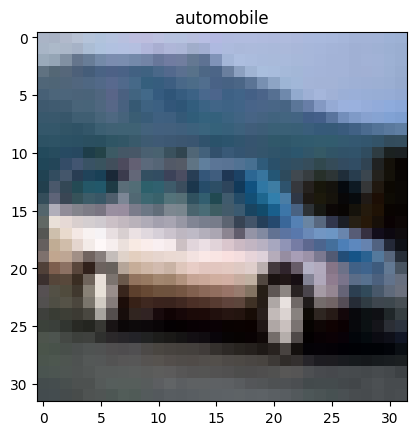

In [7]:
plt.imshow(cifar[4][0])
plt.title(CIFAR10_LABEL[cifar.targets[4]])


def plot_image(image: PIL.Image.Image, label: str):
    
    plt.title(label)
    plt.axis('off')

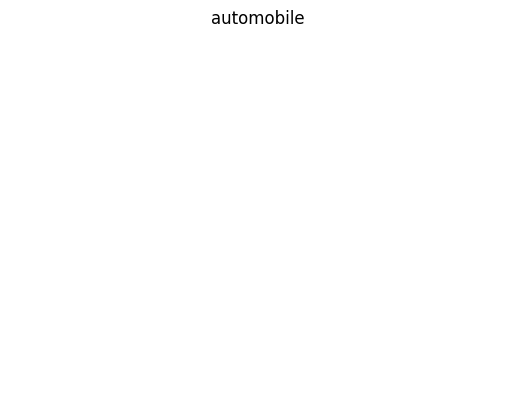

In [8]:
for i in range(5):
    plot_image(cifar[i][0], CIFAR10_LABEL[cifar.targets[i]])

## Custom Dataset

In [9]:
'''
CIFAR10 데이터셋 커스터 마이징
'''
class CustomDataset(Dataset):
    def __init__(self, train, data_dir='./CIFAR_10_Custom'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
train_dataset = CustomDataset(train=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29756442.04it/s]


Extracting ./CIFAR_10_Custom/cifar-10-python.tar.gz to ./CIFAR_10_Custom


In [11]:
test_dataset = CustomDataset(train=False)

Files already downloaded and verified


<Image no.0>
torch.Size([3, 32, 32])
frog
<Image no.1>
torch.Size([3, 32, 32])
truck
<Image no.2>
torch.Size([3, 32, 32])
truck
<Image no.3>
torch.Size([3, 32, 32])
deer


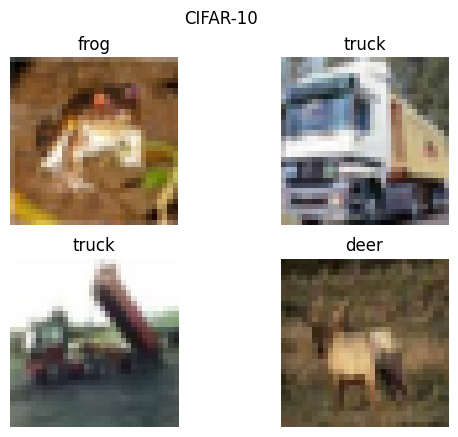

In [12]:
fig = plt.figure()
plt.suptitle('CIFAR-10')
for i in range(4):
    print(f"<Image no.{i}>")
    
    image, label_idx = train_dataset[i]
    label = CIFAR10_LABEL[label_idx]
    
    plt.subplot(2,2,i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    
    toTensor = transforms.ToTensor()
    image = toTensor(image)
    
    
    print(image.shape)
    
    print(label)

## Collate_fn

In [13]:
def collate_fn(data_samples: list[tuple[PIL.Image.Image, int]])-> tuple:
    batch_x, batch_y = [], []
    toTensor = transforms.ToTensor()
#     images, labels = zip(*data_samples)
#     batch_x = [toTensor(x) for x in images]
#     batch_y = labels
    for i, (img, label) in enumerate(data_samples):
        # img : (H, W, C)
        # toTensor(img) -> (C, H, W)
        batch_x.append(toTensor(img))
        batch_y.append(torch.Tensor([label]))
    batch_x = torch.stack(batch_x).float()
    batch_y = torch.tensor(batch_y).long()
    
    return batch_x, batch_y

In [14]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )

In [15]:
image, label = next(iter(train_loader))

print(image.shape)
print(label.shape)
print(image, label)

torch.Size([8, 3, 32, 32])
torch.Size([8])
tensor([[[[0.9843, 1.0000, 0.9961,  ..., 0.9725, 1.0000, 1.0000],
          [0.9765, 0.9961, 0.9882,  ..., 0.8235, 1.0000, 0.9922],
          [0.9765, 0.9961, 0.9882,  ..., 0.7765, 1.0000, 0.9922],
          ...,
          [0.2549, 0.2980, 0.2549,  ..., 0.3765, 0.2824, 0.2706],
          [0.2471, 0.2275, 0.2667,  ..., 0.4275, 0.3098, 0.2706],
          [0.2275, 0.2392, 0.2745,  ..., 0.4510, 0.3804, 0.3255]],

         [[0.9961, 0.9961, 1.0000,  ..., 0.9725, 1.0000, 1.0000],
          [0.9843, 0.9882, 0.9961,  ..., 0.8196, 1.0000, 0.9961],
          [0.9843, 0.9882, 0.9961,  ..., 0.7725, 1.0000, 0.9961],
          ...,
          [0.3020, 0.3255, 0.2667,  ..., 0.6745, 0.6706, 0.6588],
          [0.2902, 0.2588, 0.2863,  ..., 0.6863, 0.6588, 0.6353],
          [0.2627, 0.2706, 0.2941,  ..., 0.6235, 0.6588, 0.6549]],

         [[0.9725, 0.9882, 0.9882,  ..., 0.9843, 0.9922, 0.9882],
          [0.9843, 0.9804, 0.9647,  ..., 0.8392, 0.9922, 0.9765],

## Transforms (Data Augmentation)

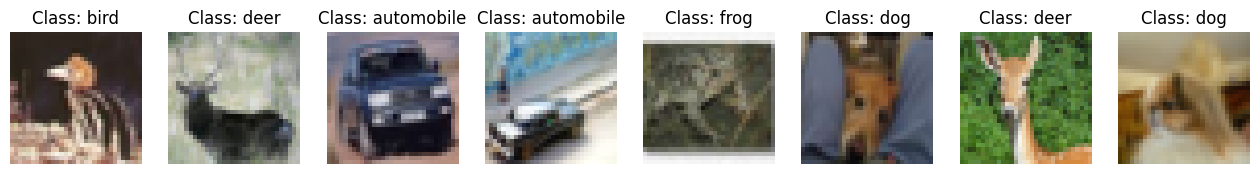

In [16]:
def visualize_batch(batch, augment=None):
    images, labels = batch
    batch_size = images.shape[0]
    pltsize = 2
    plt.figure(figsize=(batch_size * pltsize, pltsize))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(augment(images[i]) if augment else images[i], (1, 2, 0)))
        plt.title('Class: ' + str(CIFAR10_LABEL[labels[i].item()]))
    
sample_batch = next(iter(train_loader))
visualize_batch(sample_batch)

## Apply Data augmentation usuing torchvision.transforms Module

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

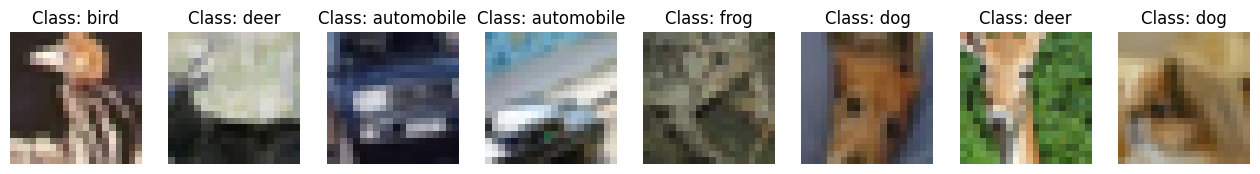

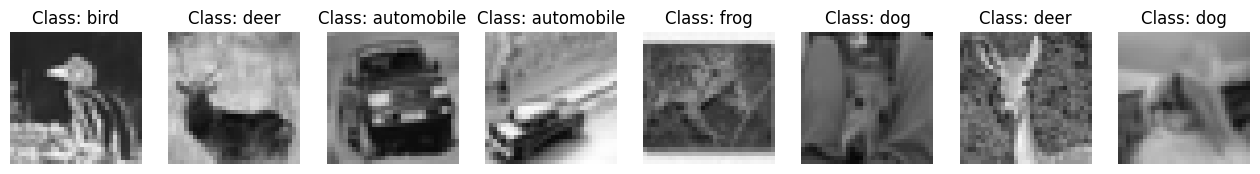

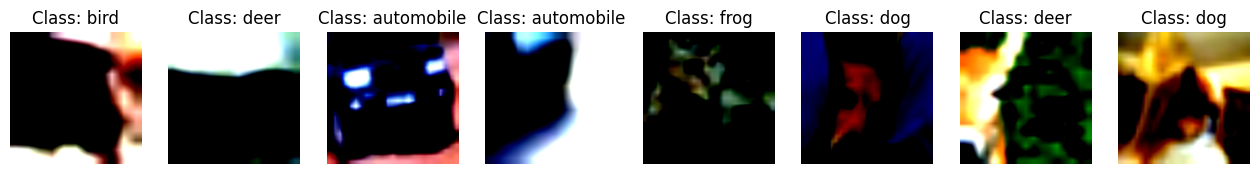

In [17]:
from torchvision.transforms import v2

visualize_batch(sample_batch, augment=transforms.CenterCrop(20))
visualize_batch(sample_batch, augment=transforms.Grayscale(num_output_channels=3))

t = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

visualize_batch(sample_batch, augment=t)




In [18]:
augment_pool = [
    v2.Grayscale(num_output_channels=3),
    v2.functional.hflip,
    v2.functional.vflip,
]

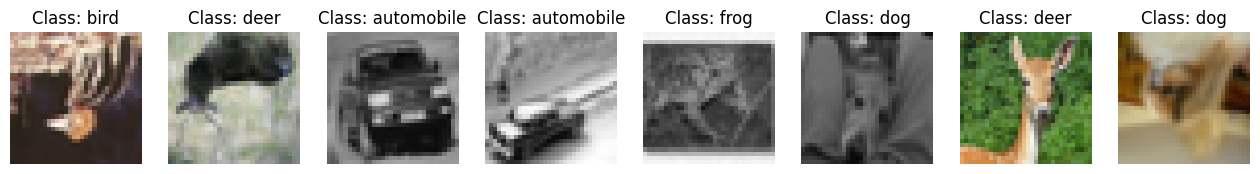

In [19]:
class RandomAugmentation:
    def __init__(self, augment_pool, prob=0.5):
        self.augment_pool = augment_pool
        self.prob = prob
        
    def __call__(self, image):
        import random
        augmenting = random.choices([True, False], weights=[self.prob, 1 - self.prob])[0]
        if augmenting:
            selected_aug = random.choice(self.augment_pool)
            image = selected_aug(image)
        return image
    
visualize_batch(sample_batch, augment=RandomAugmentation(augment_pool, 0.8))

In [20]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [21]:
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir='./CIFAR_10'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, data_samples: PIL.Image.Image):
        batch_x, batch_y = [], []
        toTensor = v2.ToTensor()
        for x, y in data_samples:
            img_tensor = toTensor(self.transform(x))
            if self.transform:
                image_tensor = self.transform(image)
            batch_x.append(img_tensor)
            batch_y.append(torch.Tensor([y]))
        
        batch_x, batch_y = torch.stack(batch_x).float(), torch.cat(batch_y).long()
        return batch_x, batch_y


In [22]:
train_dataset = CustomDataset(train=True, transform=RandomAugmentation(augment_pool, 0.5))
test_dataset = CustomDataset(train=False, transform=RandomAugmentation(augment_pool, 0.5))

Files already downloaded and verified
Files already downloaded and verified


In [23]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )

In [24]:
sample_batch = next(iter(train_loader))

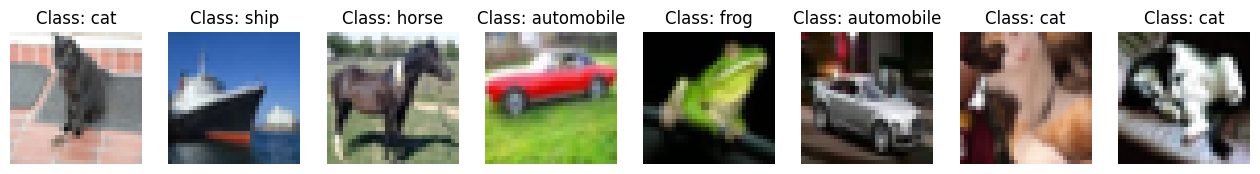

In [25]:
visualize_batch(sample_batch)

# Multi Layer Perceptron


In [26]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
def train(model, train_loader, optimizer, criterion, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step() # lr scheduler decays the learning rate every epoch
    train_loss /= len(train_loader.dataset) # 평균 loss
    train_acc = 100. * correct / len(train_loader.dataset) # accuracy
    return train_loss, train_acc

In [28]:
def evaluate(model, test_loader, return_samples=False):
    model.eval()
    test_loss = 0
    correct = 0
    
    random_idx = np.random.randint(len(test_loader))
    samples = None
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(tqdm(test_loader)):
            if batch_idx == random_idx:
                samples = (image, label)
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return (test_loss, test_acc, samples) if return_samples is True else (test_loss, test_acc)

In [29]:
model = MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [30]:
learning_rate = 0.001
epochs = 6
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)


In [31]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH: {epoch}], \tModel: MLP, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MLP, 	Test Loss: 0.0145, 	Test Accuracy: 33.32 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: MLP, 	Test Loss: 0.0140, 	Test Accuracy: 36.27 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: MLP, 	Test Loss: 0.0135, 	Test Accuracy: 38.38 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: MLP, 	Test Loss: 0.0131, 	Test Accuracy: 41.02 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: MLP, 	Test Loss: 0.0127, 	Test Accuracy: 42.46 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: MLP, 	Test Loss: 0.0127, 	Test Accuracy: 42.72 % 



# Convolutional Neural Network (CNN)


In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8 , kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8 * 16 * 16, 10)
        )
        print(self.conv)
    def forward(self, x):
        return self.conv(x)


In [33]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2048, out_features=10, bias=True)
)


## Hyperparameter Tuning

In [34]:
learning_rate = 0.001
epochs = 10
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)


In [35]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH: {epoch}], \tModel: CNN, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	Test Loss: 0.0136, 	Test Accuracy: 40.57 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	Test Loss: 0.0127, 	Test Accuracy: 43.79 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	Test Loss: 0.0124, 	Test Accuracy: 44.58 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	Test Loss: 0.0118, 	Test Accuracy: 47.41 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	Test Loss: 0.0118, 	Test Accuracy: 47.88 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: CNN, 	Test Loss: 0.0114, 	Test Accuracy: 49.15 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: CNN, 	Test Loss: 0.0113, 	Test Accuracy: 49.16 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: CNN, 	Test Loss: 0.0112, 	Test Accuracy: 50.27 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: CNN, 	Test Loss: 0.0111, 	Test Accuracy: 50.38 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: CNN, 	Test Loss: 0.0110, 	Test Accuracy: 50.86 % 



# Learning Rate Scheduling

In [36]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2048, out_features=10, bias=True)
)


In [37]:
lr = 0.001
epochs = 10
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)


In [38]:
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [39]:
for epoch in range(1, epochs + 1):
    curr_lr = scheduler.get_last_lr()[0]
    train(model, train_loader, optimizer, criterion, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tModel: CNN, \tLR: {curr_lr: .4f}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	LR:  0.0010, 	Test Loss: 0.0137, 	Test Accuracy: 40.20 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	LR:  0.0009, 	Test Loss: 0.0127, 	Test Accuracy: 43.18 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	LR:  0.0008, 	Test Loss: 0.0123, 	Test Accuracy: 45.15 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	LR:  0.0007, 	Test Loss: 0.0121, 	Test Accuracy: 45.67 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	LR:  0.0007, 	Test Loss: 0.0119, 	Test Accuracy: 46.59 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: CNN, 	LR:  0.0006, 	Test Loss: 0.0117, 	Test Accuracy: 47.79 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: CNN, 	LR:  0.0005, 	Test Loss: 0.0116, 	Test Accuracy: 47.80 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: CNN, 	LR:  0.0005, 	Test Loss: 0.0116, 	Test Accuracy: 47.65 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: CNN, 	LR:  0.0004, 	Test Loss: 0.0116, 	Test Accuracy: 47.29 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: CNN, 	LR:  0.0004, 	Test Loss: 0.0115, 	Test Accuracy: 48.74 % 



In [40]:
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [41]:
log_dir = './runs/cnn-tutorial'
writer = SummaryWriter(log_dir=log_dir)

In [42]:
%load_ext tensorboard

In [43]:
"""
Utils
"""
def matplotlib_imshow(img):
    npimg = img.numpy()
    npimg = np.moveaxis(npimg, 0,-1)
    plt.imshow(npimg)
    
def images_to_probs(model, images):
    output = model(images.to(DEVICE))
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(out, dim=0)[pred_idx].item() for pred_idx, out in zip(preds, output)]

def plot_classes_preds(model, images, labels):
    preds, probs = images_to_probs(model, images)
    fig = plt.figure(figsize=(12,24))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            CIFAR10_LABEL[preds[idx]],
            probs[idx] * 100.,
            CIFAR10_LABEL[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))
    
    return fig

In [44]:
lr = 0.001
epochs = 10
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)


In [45]:
for epoch in range(1, epochs + 1):
    curr_lr = scheduler.get_last_lr()[0]
    
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, scheduler)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)
    
    test_loss, test_accuracy, samples = evaluate(model=model, test_loader=test_loader, return_samples=True)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_accuracy, epoch)
    
    images, labels = samples
    
    writer.add_figure("Prediction vs Actuals", plot_classes_preds(model, images, labels))
    
    print(f"\n[EPOCH: {epoch}], \tModel: CNN, \tLR: {curr_lr: .4f}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	LR:  0.0003, 	Test Loss: 0.0117, 	Test Accuracy: 47.46 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	LR:  0.0003, 	Test Loss: 0.0113, 	Test Accuracy: 49.34 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	LR:  0.0003, 	Test Loss: 0.0113, 	Test Accuracy: 49.72 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	LR:  0.0003, 	Test Loss: 0.0111, 	Test Accuracy: 50.81 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	LR:  0.0002, 	Test Loss: 0.0112, 	Test Accuracy: 49.42 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: CNN, 	LR:  0.0002, 	Test Loss: 0.0111, 	Test Accuracy: 49.81 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: CNN, 	LR:  0.0002, 	Test Loss: 0.0111, 	Test Accuracy: 50.49 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: CNN, 	LR:  0.0002, 	Test Loss: 0.0109, 	Test Accuracy: 51.00 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: CNN, 	LR:  0.0002, 	Test Loss: 0.0109, 	Test Accuracy: 51.37 % 



0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: CNN, 	LR:  0.0001, 	Test Loss: 0.0112, 	Test Accuracy: 50.04 % 



In [46]:
hparam_dict = {
    "lr": learning_rate,
    "num_epochs": epochs,
    "batch_size": batch_size,
}

metric_dict = {
    "accuracy": test_accuracy   
}

writer.add_hparams(hparam_dict, metric_dict)

In [47]:
writer.flush()
writer.close()

In [48]:
%ls ./runs/cnn-tutorial

1696927980.384309/  events.out.tfevents.1696927825.6a8de947e801.23.0


In [49]:
%tensorboard --logdir ./runs